In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import xgboost as xgb
import shap


# set seed for reproducibility
np.random.seed(123)

c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def step_dataframe(df, group_col, step_dict, num_steps=1):
    """
    Create variations of a dataframe by stepping values up and down in specified columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    group_col : str
        Column name to group by or 'index' to group by the index
    step_cols : list
        List of column names to apply steps to
    step_sizes : list
        List of step sizes corresponding to step_cols
    num_steps : int, default=1
        Number of steps in each direction (up and down)
        
    Returns:
    --------
    pandas.DataFrame
        A new dataframe with stepped values
    """
    
    # Create a copy of the original dataframe to avoid modifying it
    result_df = df.copy()
    
    # Add a column to identify original rows
    result_df['step_id'] = 0

    
    # Handle the case where group_col is the index
    if group_col == 'index':
        # Use the index for grouping
        groups = df.groupby(df.index)
        is_index_grouping = True
    else:
        # Use a regular column for grouping
        groups = df.groupby(group_col)
        is_index_grouping = False
    
    # For each group
    for group_name, group_df in groups:
        # For each step (both positive and negative)
        for step in range(-num_steps, num_steps + 1):
            if step == 0:  # Skip step 0 as it's already in the original data
                continue
                
            # Create a copy of the group
            step_df = group_df.copy()
            
            # Set the step_id
            step_df['step_id'] = step
            
            # Apply the step to each column
            for col, step_size in step_dict.items():
                step_df[col] = step_df[col] + (step * step_size)
            
            # Append to the result
            result_df = pd.concat([result_df, step_df], ignore_index=not is_index_grouping)
    
    return result_df

# Generate the distribution of college data and make predictions per person and average together.

In [22]:
with open('C:/Users/sethl/OneDrive/Programming Stuff/Modeling Folder/NFL Models/wr_model/model_evaluation/data/full_predictions.pkl', 'rb') as f:
    data = pickle.load(f)


with open('C:/Users/sethl/OneDrive/Programming Stuff/Modeling Folder/NFL Models/wr_model/model_evaluation/data/model_df.pkl', 'rb') as f:
    model_df = pickle.load(f)


with open('C:/Users/sethl/OneDrive/Programming Stuff/Modeling Folder/NFL Models/wr_model/model_evaluation/data/season_context.pkl', 'rb') as f:
    season_context = pickle.load(f)

In [23]:
change = step_dataframe(data, group_col = 'index',
                         step_dict = {
    'athleticism_score': 1,
    'wt': 2.5, 'arm_in': 0.125, 'wing_in': 0.25,
    'c_reps': 0.5, 'c_10y': -0.025, 'c_40y': -0.025, 'c_vj_in': 0.5, 'c_bj_in': 1,
    'c_3c': -0.025, 'c_ss20': -0.025, 'est_40y': -0.025
    },
                         num_steps=2)

# Make predictions

In [ ]:
# Make predictions using the best model for the full sample

In [24]:
import mlflow
from mlflow import MlflowClient

client = MlflowClient()
mlflow.set_tracking_uri('http://localhost:5000')
# Set model version alias
model_name = "wr_model_v1"
# model_version_alias = "stately-worm-429"
model_version = 43

model = mlflow.sklearn.load_model(f"models:/{model_name}/{model_version}")

In [50]:
prediction_set = change.drop(columns = ['step_id'])
output = model.predict(prediction_set)

output = pd.Series(output, index=prediction_set.index) 
full_output = prediction_set.copy()
full_output['predicted_label'] = output
full_output = pd.merge(full_output, model_df['target'], how = 'left', left_index = True, right_index = True)
new_data = data.copy()
new_data['predicted_label'] = model.predict(data)
new_data['mean_label'] = full_output.groupby('ID')['predicted_label'].mean()
new_data['max_label']  = full_output.groupby('ID')['predicted_label'].max()
new_data['min_label']  = full_output.groupby('ID')['predicted_label'].min()
new_data = pd.merge(new_data, season_context, how = 'left', left_index = True, right_index = True)
new_data = new_data.sort_values(by='predicted_label', ascending=False)


new_data = pd.merge(new_data, model_df['target'], how = 'left', left_index=True, right_index=True)
new_data = new_data[['Last_Season', 'target', 'predicted_label', 'min_label', 'mean_label', 'max_label'] + [col for col in new_data.columns if col not in ['Last_Season', 'target', 'predicted_label', 'mean_label', 'max_label', 'min_label']]]


current_year = new_data[new_data['Last_Season'] == 2024].drop(columns = ['target'])
new_data['Diff'] = new_data['predicted_label'] - new_data['target']
new_data = new_data[['Last_Season','target', 'predicted_label', 'Diff', 'min_label', 'mean_label', 'max_label'] + [col for col in new_data.columns if col not in ['Last_Season','target', 'predicted_label','Diff', 'mean_label', 'max_label', 'min_label']]]

other_prospects = new_data[new_data['Last_Season'] != 2024]


top5 = new_data[new_data['Last_Season'] != 2024].sort_values(by = 'Diff', ascending=False).head(10)
bottom5 = new_data[new_data['Last_Season'] != 2024].sort_values(by = 'Diff', ascending=True).head(10)

current_year.to_csv('current_year_wr.csv')
other_prospects.to_csv('full_list_prospects_wr.csv')

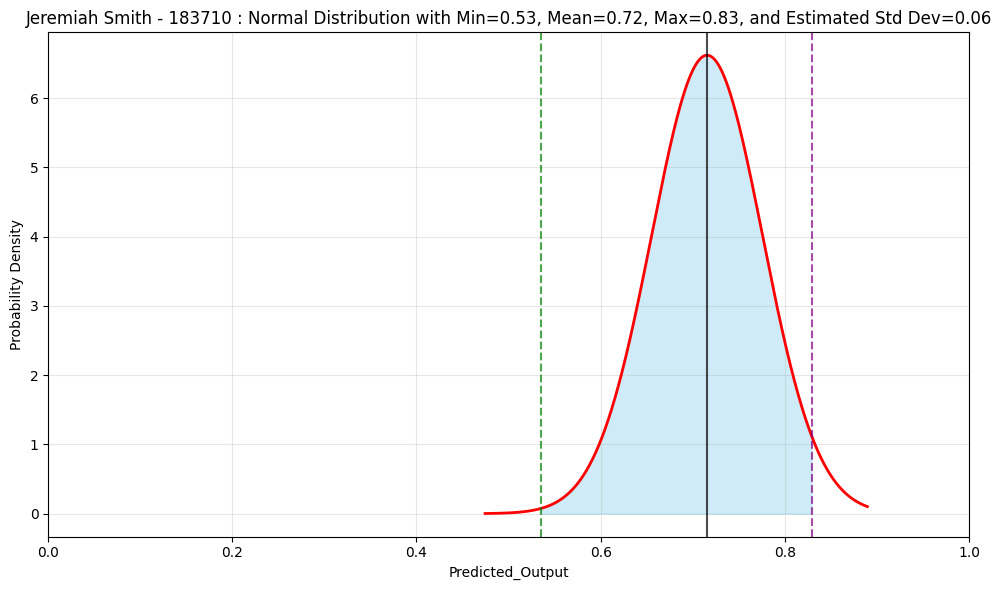

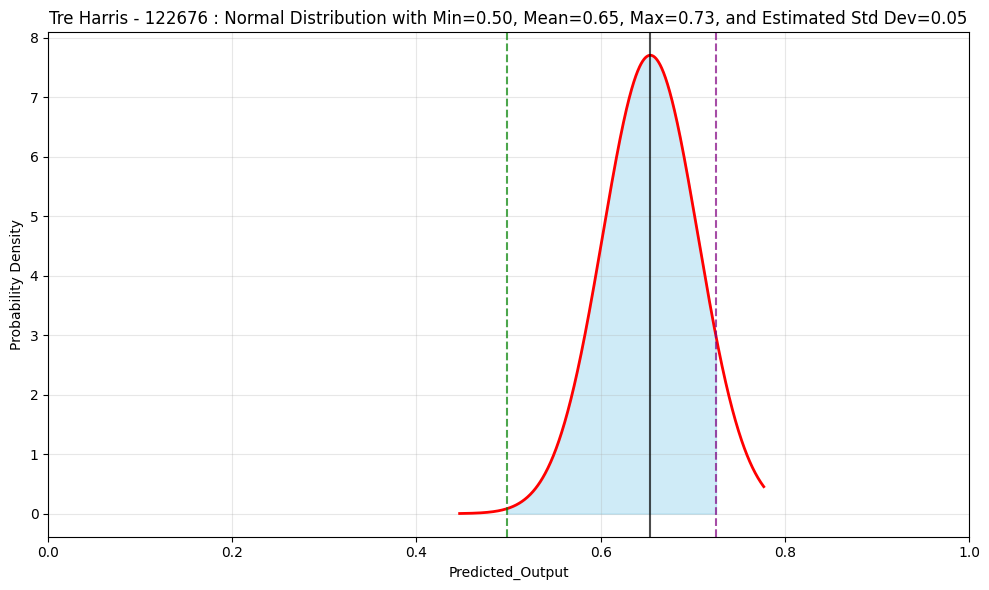

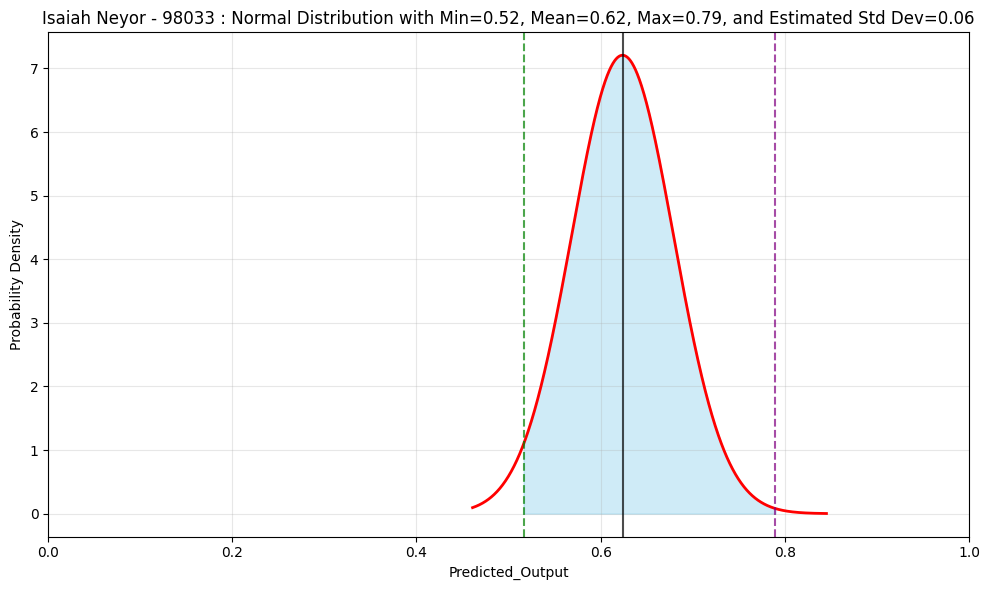

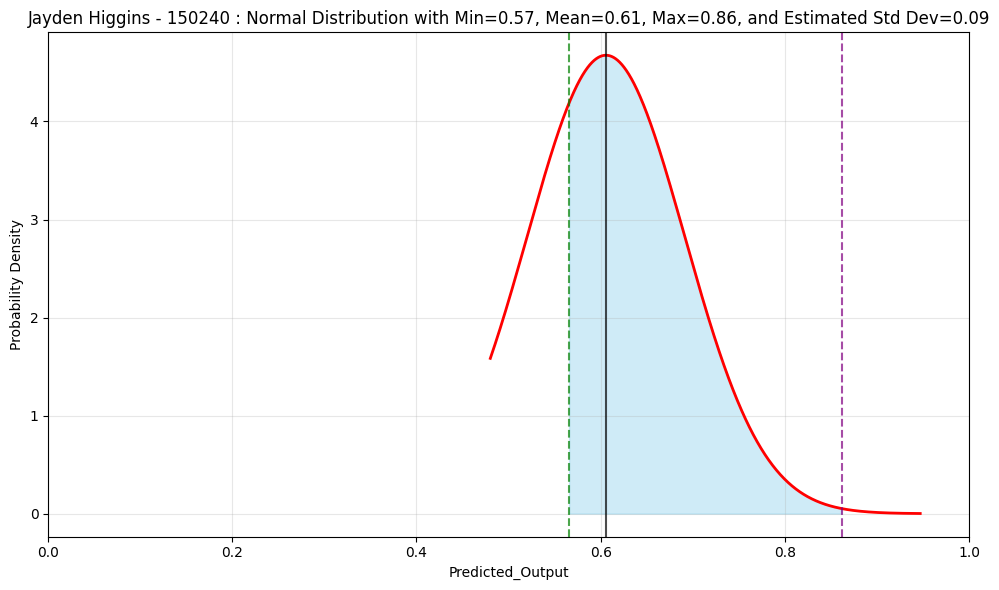

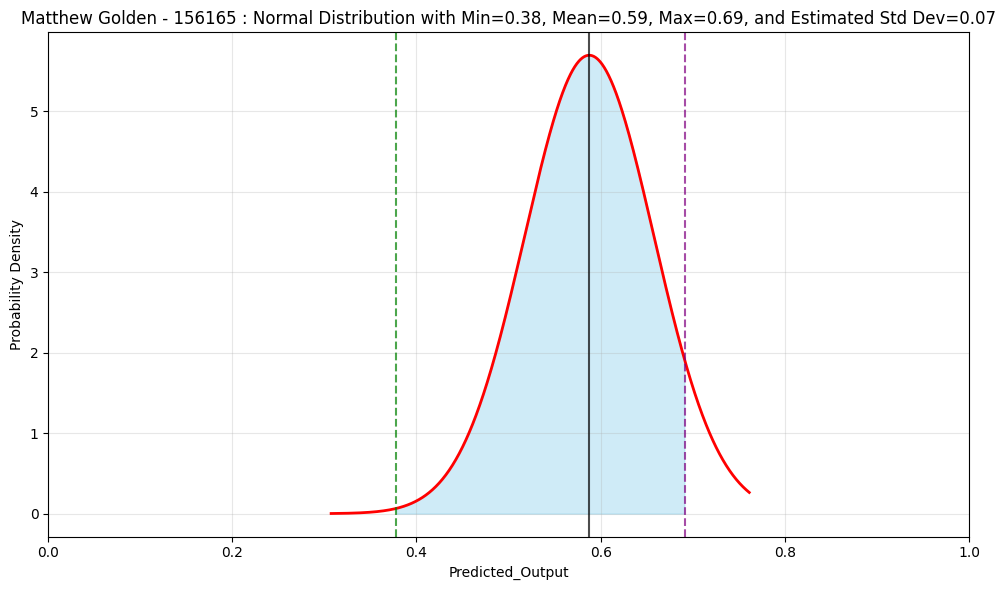

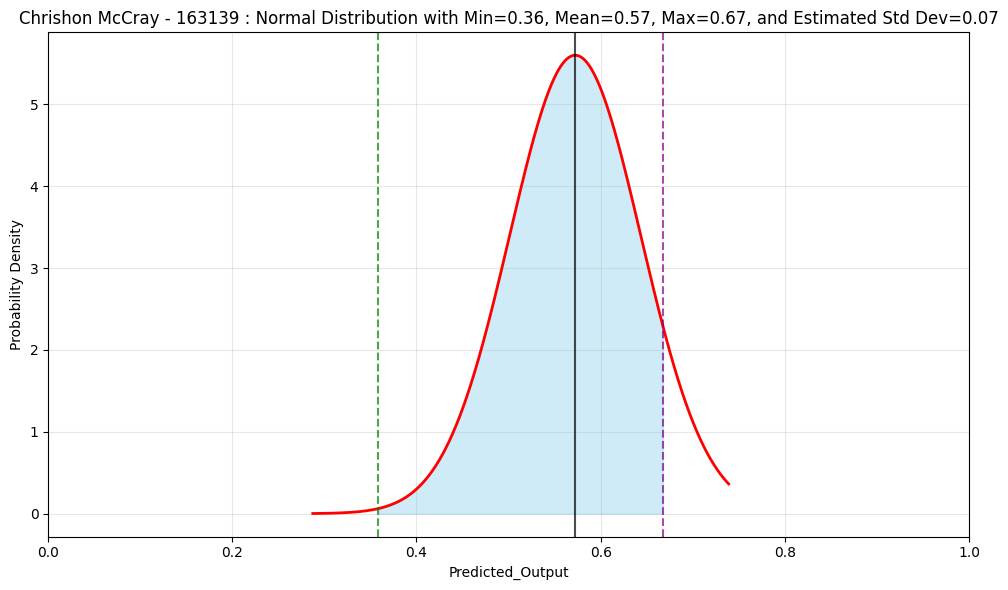

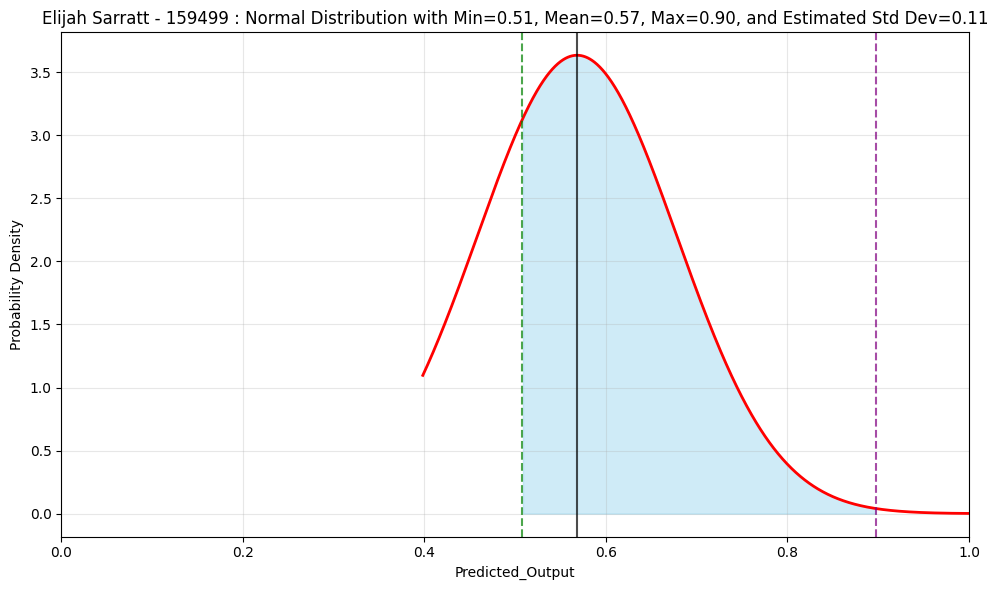

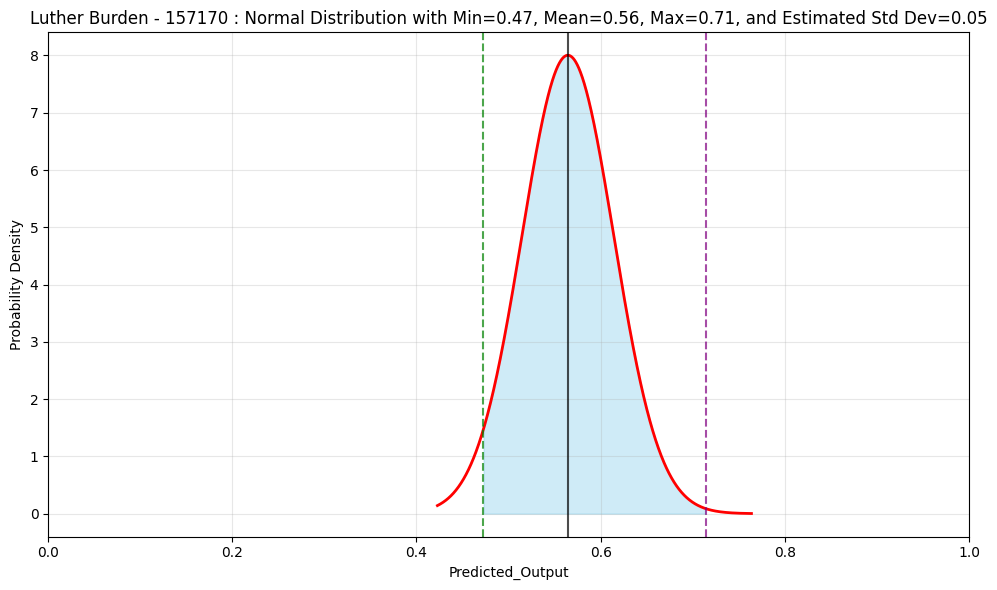

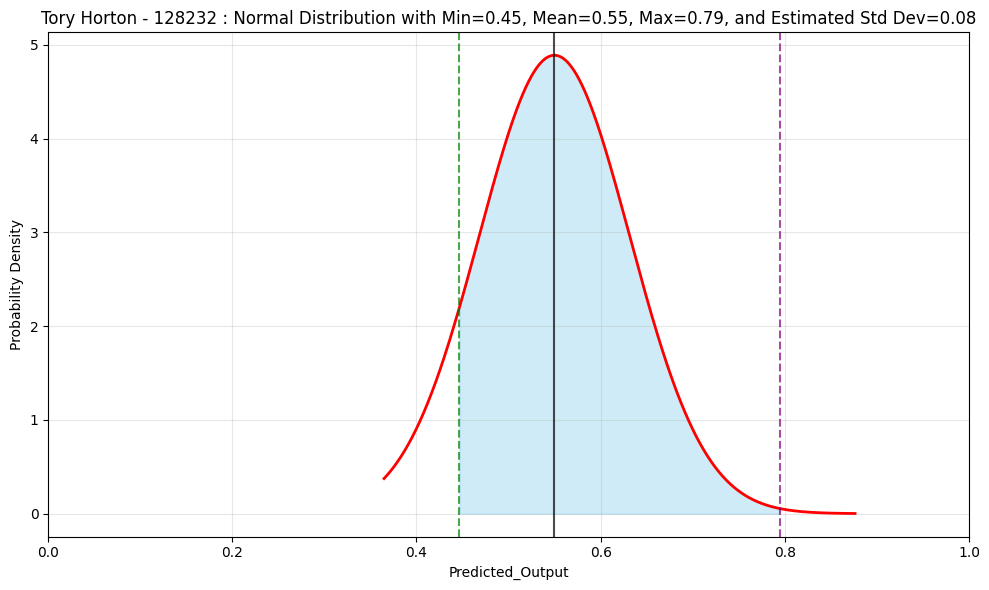

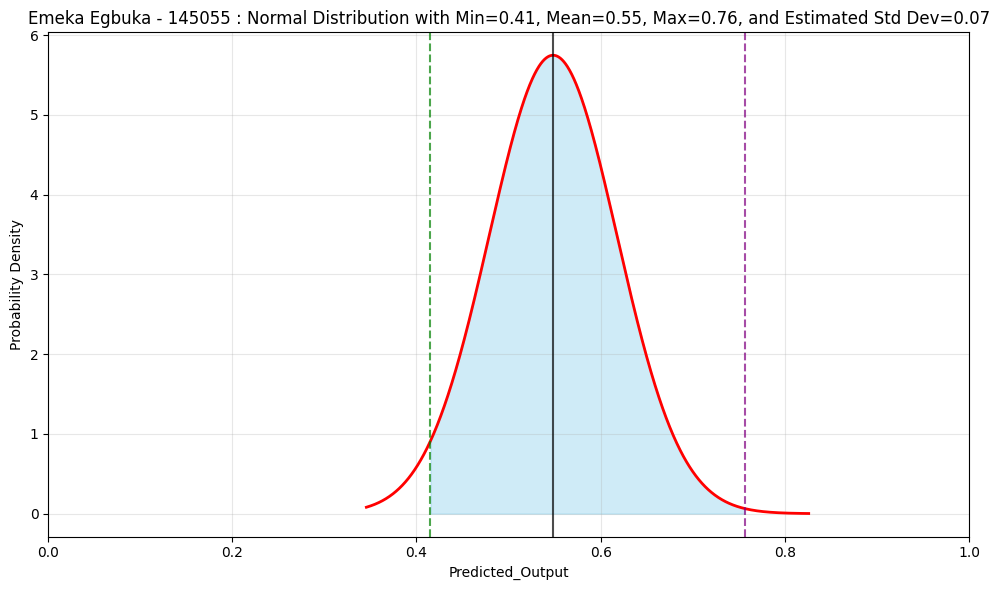

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

for i in range(10):
    plot_df = new_data[new_data['Last_Season'] == 2024]
    row = plot_df.iloc[i, :].copy()
    # Parameters
    mean = row['predicted_label']
    min_val =  row['min_label']
    max_val =  row['max_label']
    player = row.name

    distance_to_min = mean - min_val
    distance_to_max = max_val - mean
    max_distance = max(distance_to_min, distance_to_max)
    std_dev_estimate2 = max_distance / 3  # Assuming max distance is 3 standard deviations

    # Choose appropriate std_dev estimation method
    std_dev = std_dev_estimate2  # Change to std_dev_estimate2 if needed

    # Generate x values for plotting
    x = np.linspace(min_val - std_dev, max_val + std_dev, 1000)

    # Calculate normal PDF
    y = stats.norm.pdf(x, mean, std_dev)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the normal distribution
    plt.plot(x, y, 'r-', lw=2, label='Normal Distribution')

    # Shade the area between min and max
    plt.fill_between(x, y, where=(x >= min_val) & (x <= max_val), 
                    color='skyblue', alpha=0.4, label='Min-Max Range')

    # Add vertical lines for min, max, and mean
    plt.axvline(min_val, color='green', linestyle='--', alpha=0.7, label=f'Minimum = {min_val}')
    plt.axvline(max_val, color='purple', linestyle='--', alpha=0.7, label=f'Maximum = {max_val}')
    plt.axvline(mean, color='black', linestyle='-', alpha=0.7, label=f'Mean = {mean}')

    # Add labels and title
    plt.xlabel('Predicted_Output')
    plt.ylabel('Probability Density')
    plt.title(f'{player} : Normal Distribution with Min={min_val:.2f}, Mean={mean:.2f}, Max={max_val:.2f}, and Estimated Std Dev={std_dev:.2f}')
    plt.grid(True, alpha=0.3)


    plt.xlim(0,1)
    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\sethl\AppData\Local\Temp\ipykernel_16020\794154261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = row['predicted_label'][0]
C:\Users\sethl\AppData\Local\Temp\ipykernel_16020\794154261.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_val =  row['min_label'][0]
C:\Users\sethl\AppData\Local\Temp\ipykernel_16020\794154261.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val =  row['max_label'][0]


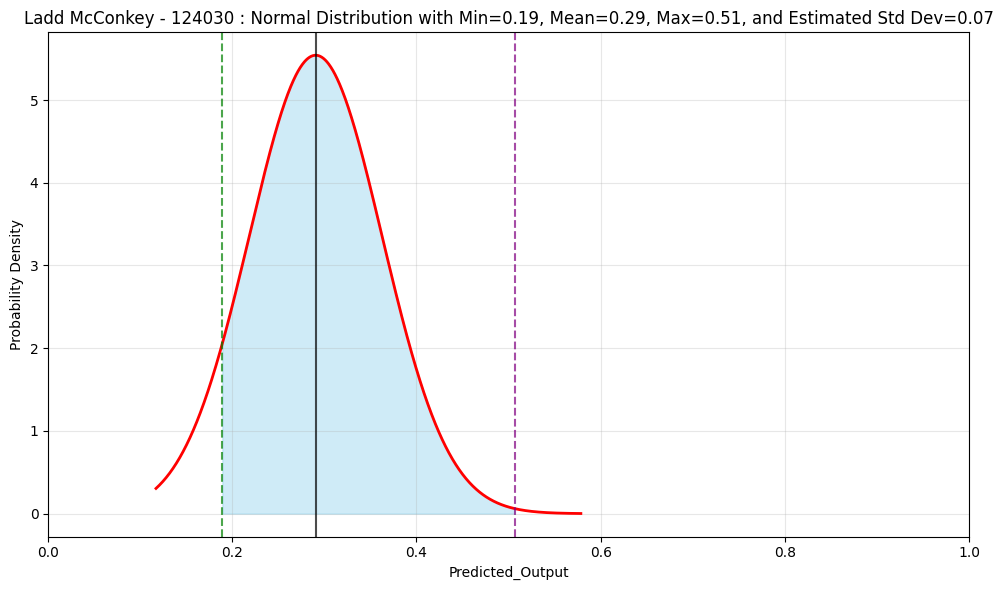

In [45]:


plot_df = new_data[new_data.index == 'Ladd McConkey - 124030']
row = plot_df.copy()
# Parameters
mean = row['predicted_label'][0]
min_val =  row['min_label'][0]
max_val =  row['max_label'][0]
player = 'Ladd McConkey - 124030'

distance_to_min = mean - min_val
distance_to_max = max_val - mean
max_distance = max(distance_to_min, distance_to_max)
std_dev_estimate2 = max_distance / 3  # Assuming max distance is 3 standard deviations

# Choose appropriate std_dev estimation method
std_dev = std_dev_estimate2  # Change to std_dev_estimate2 if needed

# Generate x values for plotting
x = np.linspace(min_val - std_dev, max_val + std_dev, 1000)

# Calculate normal PDF
y = stats.norm.pdf(x, mean, std_dev)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the normal distribution
plt.plot(x, y, 'r-', lw=2, label='Normal Distribution')

# Shade the area between min and max
plt.fill_between(x, y, where=(x >= min_val) & (x <= max_val), 
                color='skyblue', alpha=0.4, label='Min-Max Range')

# Add vertical lines for min, max, and mean
plt.axvline(min_val, color='green', linestyle='--', alpha=0.7, label=f'Minimum = {min_val}')
plt.axvline(max_val, color='purple', linestyle='--', alpha=0.7, label=f'Maximum = {max_val}')
plt.axvline(mean, color='black', linestyle='-', alpha=0.7, label=f'Mean = {mean}')

# Add labels and title
plt.xlabel('Predicted_Output')
plt.ylabel('Probability Density')
plt.title(f'{player} : Normal Distribution with Min={min_val:.2f}, Mean={mean:.2f}, Max={max_val:.2f}, and Estimated Std Dev={std_dev:.2f}')
plt.grid(True, alpha=0.3)


plt.xlim(0,1)
# Show the plot
plt.tight_layout()
plt.show()